In [26]:
%%capture
!pip install sentence_transformers
!pip install umap-learn
!pip install hdbscan
!pip install BERTopic
!pip install datasets

In [27]:
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import json
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from hdbscan import HDBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datasets import load_dataset, Dataset
import pickle
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import os
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from io import StringIO


# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 10}
axes = {
        'titlesize' : 20,
        'labelsize' : 18}
figure = {'figsize':(6,4),
         'autolayout':True}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)

In [28]:
def cluster_and_plot(embeddings, umap_bool=True, umap_args=None, hdbscan_args=None,
                     l2_norm=False):
  if umap_args is None:
    umap_args = {}
  if hdbscan_args is None:
    hdbscan_args = {'min_cluster_size':5, 'metric':'euclidean',
                      'cluster_selection_method':'eom'}
  if umap_bool: # Use UMAP for dimensionality reduction
    reduced_embeddings = umap.UMAP(**umap_args).fit_transform(embeddings)
  else: # use tsne
    tsne = TSNE(random_state=0, n_iter=1000, n_components=2, perplexity=30,
                metric='cosine')
    reduced_embeddings = tsne.fit_transform(embeddings)
  if l2_norm: #normalization only for clustering
    l2_norms = np.linalg.norm(reduced_embeddings, axis=0)
    l2_norms = l2_norms.reshape(1, -1)
    reduced_embeddings = reduced_embeddings / l2_norms
  # Let's use HDBSCAN to find clusters
  hdbscan_model = HDBSCAN(**hdbscan_args)
  hdbscan_model.fit(reduced_embeddings)
  clusters = hdbscan_model.labels_
  # organize in a df
  df = pd.DataFrame(np.hstack([reduced_embeddings, clusters.reshape(-1, 1)]),
    columns=["Dim 1", "Dim 2", "cluster"], index=embeddings.index).sort_values("cluster")
  df.cluster = df.cluster.astype(int).astype(str)
  # plot
  fig = sns.scatterplot(data=df, x='Dim 1', y='Dim 2', hue='cluster',
    linewidth=0, legend=False, s=30, alpha=0.5)

  return fig, df



## Let's start with word similarity

* I will use `word2vec` and `GloVe` as in [Part 1](https://colab.research.google.com/drive/1-jlhZ7Uz9Q3cgznsM1yuFBGbZXzrGBTe#scrollTo=DWZAeNPWssWj)

In [29]:
# these are the most similar words using the term-doc and term-term matrices from the previous post
data = {
    'term-doc matrix': ['assumption', 'show', 'business', 'gain', 'material'],
    'term-term matrix': ['inference', 'one', 'business', 'model', 'ex-ante']
}

index = ['causal', 'model', 'data', 'predict', 'storytelling']

dfs = pd.DataFrame(data, index=index)
dfs

,term-doc matrix,term-term matrix
causal,assumption,inference
model,show,one
data,business,business
predict,gain,model
storytelling,material,ex-ante


In [30]:
# This is used in the figure for BERT embeddings
arrays = [
    [0.1, 8.8, 9.1, 4.0, 7.2, -3.4, 0.7, 8.9, 4.5, 6.5, 23.1, 8.2, 1.1, 4.5],
    [1.2, 3.4, 5.6, 7.8, 9.0, -1.2, 2.3, 4.5, 6.7, 8.9, 10.1, 1.3, 4.5, 16.7],
    [-2.3, 4.5, 6.7, 8.9, 1.1, 1.3, 1.5, 6.7, 18.9, 0.1, 2.3, 4.5, -2.7, 28.9],
    [3.1, 5.2, 7.3, 9.4, 1.5, 3.6, 1.7, 7.8, -1.9, 1.0, 2.1, 5.2, -27.3, 29.4],
    [4.0, 6.1, 8.2, 0.3, -2.4, 4.5, 1.6, 8.7, 2.8, 2.9, 4.0, 2.6, -2, 30.3],
    #[5.9, 7.8, 9.7, -11.6, 3.5, 5.4, 1.3, -1.2, 2.1, 3.0, 4.9, 6.8, 8.7, 0.6]
]

average_array = [round(sum(col) / len(col),1) for col in zip(*arrays)]
print(average_array)


[1.2, 5.6, 7.4, 6.1, 3.3, 1.0, 1.6, 7.3, 6.2, 3.9, 8.3, 4.4, -5.3, 22.0]


In [31]:
# these pkls were created in the previous post
# you can use the reduced dataset and code from that post to create the pkl
# https://github.com/dvaughan79/data-science-hard-parts-code/blob/main/substack/myposts_smp.txt
w2vec = pd.read_pickle('w2vec.pkl')
glove = pd.read_pickle('glove.pkl')

In [32]:
def sample_words(group):
    return group.sample(n=2, replace=True) if len(group) > 1 else group

def summarize_clusters(df, nwords=10):
  df_smpl = df[df['cluster']!='-1'].groupby('cluster').apply(sample_words)
  df_clu = df.cluster.value_counts()
  try:
    df_clu.drop(index='-1', inplace=True)
  except:
    a=1
  for c, clu in enumerate(df_clu.index):
    print('-'*60)
    str_c = f'Cluster {clu} has {df_clu.loc[clu]} elements'
    print(str_c)
    list_c = [wrd for wrd in df[df.cluster==clu].sample(nwords).index]
    print(list_c)
  return None

### Note:

* With embeddings it's not obvious if we should use some sort of normalization (there are some [papers](https://arxiv.org/abs/1704.02963) that say you should do l2-normalization, others that don't.  
* Below I explore both methods.
* Note that the code uses normalization only for the clustering part, but I have elsewhere tested doing it before using dimensionality reduction.
* Also note that `sentence-embeddings` use by default l2-normalization (you can switch it off if you want)

------------------------------------------------------------
Cluster 5 has 594 elements
['affiliative', 'periods', 'overall', 'scales', 'interim', 'uniform', 'closer', 'decade', 'board', 'intelligent']
------------------------------------------------------------
Cluster 4 has 167 elements
['importantly', 'signs', 'overlap', 'sorts', 'temptation', 'oneself', 'partially', 'previously', 'subjects', 'emotionally']
------------------------------------------------------------
Cluster 1 has 100 elements
['bard', 'h_t', 'sft', 'feudal', 'pearl', 'european', 'ok', 'ref', 'da', 'jd']
------------------------------------------------------------
Cluster 0 has 87 elements
['adding', 'known', 'complaining', 'inferring', 'depict', 'arguments', 'summarized', 'explaining', 'indicating', 'reveals']
------------------------------------------------------------
Cluster 3 has 82 elements
['binomial', 'mechanistic', 'nonlinear', 'directionality', 'generative', 'deviations', 'observations', 'interpretable', '

Text(0.5, 1.0, 'UMAP + L2-normalization')

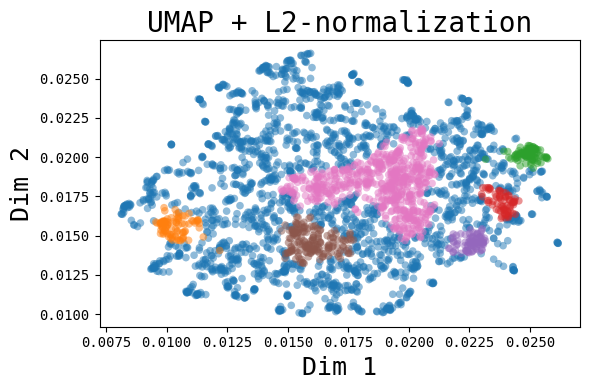

In [33]:
# UMAP + l2-normalization
umap_args = {'n_neighbors':10, 'min_dist':0.0, 'n_components':2}
hdbscan_args = {'min_cluster_size':int(0.02*w2vec.shape[0])}
fig, df = cluster_and_plot(embeddings=w2vec, umap_bool = True, umap_args = umap_args, hdbscan_args = hdbscan_args,
                           l2_norm=True)
summarize_clusters(df)
fig.set_title('UMAP + L2-normalization')

------------------------------------------------------------
Cluster 7 has 1017 elements
['equal', 'hands', 'smart', 'personnel', 'intention']
------------------------------------------------------------
Cluster 8 has 122 elements
['information', 'tuning', 'classifier', 'chatbot', 'lists']
------------------------------------------------------------
Cluster 4 has 99 elements
['versa', 'exp', 'pd', 'ml', 'jd']
------------------------------------------------------------
Cluster 6 has 77 elements
['coefficients', 'impurity', 'velocity', 'anthropic', 'subsets']
------------------------------------------------------------
Cluster 3 has 73 elements
['refine', 'transformation', 'add', 'develop', 'accessible']
------------------------------------------------------------
Cluster 1 has 57 elements
['describe', 'argued', 'clarify', 'explain', 'considers']
------------------------------------------------------------
Cluster 5 has 40 elements
['getting', 'send', 'take', 'gone', 'blown']
----------

Text(0.5, 1.0, 'UMAP')

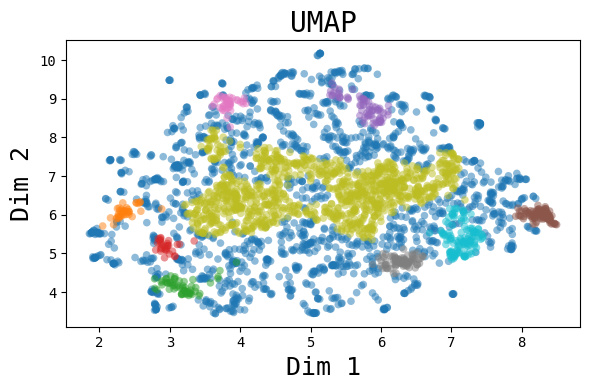

In [34]:
# let's try a clustering algorithm
umap_args = {'n_neighbors':10, 'min_dist':0.0, 'n_components':2}
hdbscan_args = {'min_cluster_size':int(0.01*w2vec.shape[0])}
fig, df = cluster_and_plot(embeddings=w2vec, umap_bool = True, umap_args = umap_args, hdbscan_args = hdbscan_args)
summarize_clusters(df, nwords=5)
fig.set_title('UMAP')

------------------------------------------------------------
Cluster 2 has 2669 elements
['career', 'accumulated', 'straightforward', 'officer', 'governed', 'evangelizer', 'adapt', 'paths', 'names', 'dashboard']
------------------------------------------------------------
Cluster 0 has 100 elements
['gans', 'ph', 'ai', 'joshua', 'apis', 'european', 'lr', 'leo', 'princeton', 'vt']
------------------------------------------------------------
Cluster 1 has 61 elements
['red', 'bus', 'takeaway', 'food', 'wearing', 'train', 'hat', 'forests', 'pizzeria', 'reservation']


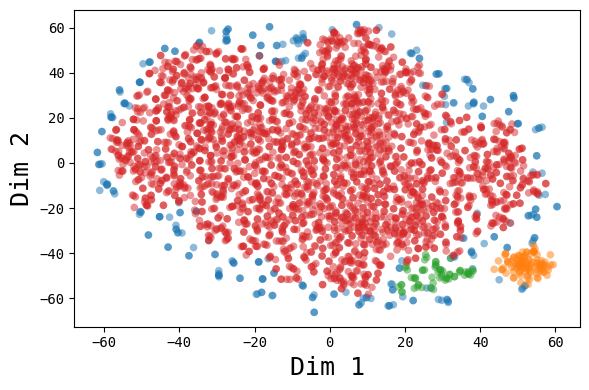

In [35]:
# WORD2VEC: TSNE
hdbscan_args = {'min_cluster_size':int(0.005*w2vec.shape[0])}
fig, df = cluster_and_plot(embeddings=w2vec, umap_bool = False, hdbscan_args = hdbscan_args)
summarize_clusters(df)

------------------------------------------------------------
Cluster 0 has 2994 elements
['necessarily', 'barro', 'ic', 'vehicles', 'simplifying', 'power', 'specialist', 'outside', 'grade', 'maps']
------------------------------------------------------------
Cluster 1 has 56 elements
['ziegler', 'schaefer', 'martin', 'andrew', 'musk', 'bert', 'alexa', 'hinton', 'granger', 'wald']


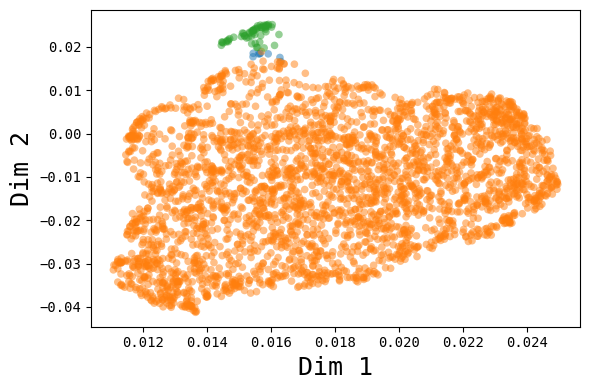

In [36]:
# GLOVE: UMAP + L2-NORM
emb_df = glove
hdbscan_args = {'min_cluster_size':int(0.01*emb_df.shape[0])}
fig, df = cluster_and_plot(embeddings=emb_df, umap_bool = True, hdbscan_args = hdbscan_args,
                           l2_norm=True)
summarize_clusters(df)

------------------------------------------------------------
Cluster 9 has 2559 elements
['unmistakably', 'revisiting', 'ever', 'shopify', 'figures', 'tested', 'panel', 'palm', 'cpo', 'github']
------------------------------------------------------------
Cluster 0 has 47 elements
['dpo', 'luc', 'godard', 'elon', 'legg', 'molnar', 'yoav', 'bard', 'jds', 'tomasz']
------------------------------------------------------------
Cluster 8 has 33 elements
['bolts', 'scope', 'horizontal', 'gradient', 'softer', 'artificial', 'zeros', 'coating', 'lowered', 'fluid']
------------------------------------------------------------
Cluster 2 has 28 elements
['general', 'labor', 'arena', 'north', 'region', 'corpus', 'rains', 'road', 'central', 'mexico']
------------------------------------------------------------
Cluster 4 has 24 elements
['chose', 'depart', 'suite', 'regard', 'direct', 'propose', 'queue', 'et', 'paris', 'places']
------------------------------------------------------------
Cluster 1 has

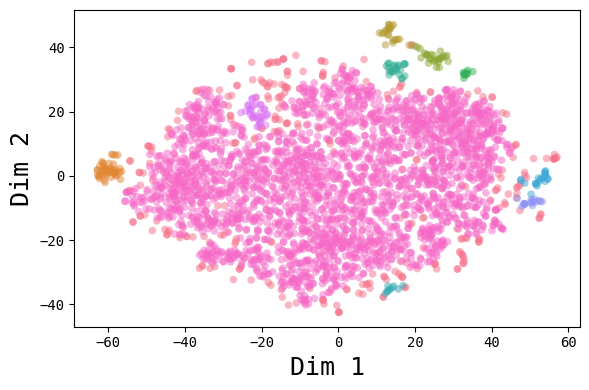

In [37]:
# GLOVE: TSNE
umap_args = {'n_neighbors':10, 'min_dist':0.0, 'n_components':2, 'metric':'cosine'}
hdbscan_args = {'min_cluster_size':int(0.003*emb_df.shape[0])}
fig, df = cluster_and_plot(embeddings=emb_df, umap_bool=False, umap_args = umap_args, hdbscan_args = hdbscan_args)
summarize_clusters(df)

# Sentence-embeddings
* As with my [previous post](https://colab.research.google.com/drive/1-jlhZ7Uz9Q3cgznsM1yuFBGbZXzrGBTe) I will use the 17 blog posts I've written fro my [Substack channel](https://decisionmatrix.substack.com/)
* To get a more interesting dataset, I'll enrich this with the chapters from [Data Science: The Hard Parts](https://www.amazon.com/s?k=data+science+the+hard+parts&crid=3CZSC6B5D82HP&sprefix=The+hard+parts%2Caps%2C692&ref=nb_sb_ss_ts-doa-p_6_14)
* I have sampled 20% of the words of all chapters and blog posts.  You can get them from my [Github repo](https://github.com/dvaughan79/data-science-hard-parts-code/blob/main/substack/myposts_and_hparts_smp.txt)

In [38]:
# models and context
data = """
Model,Context Window Size (K)
BERT, 0.512
GPT-3,2
GPT-4,32
Antropic,100
Gemini 1.5 Pro, 128
Gemini 1.5 Pro+, 1000
"""

df_mod = pd.read_csv(StringIO(data), dtype = 'str')
df_mod

,Model,Context Window Size (K)
0,BERT,0.512
1,GPT-3,2
2,GPT-4,32
3,Antropic,100
4,Gemini 1.5 Pro,128
5,Gemini 1.5 Pro+,1000


In [39]:
with open('myposts_and_hparts.txt', 'r', encoding='utf-8') as f:
    text = f.read()
dict_docs = json.loads(text)
doc_labels = list(dict_docs.keys())
full_docs_list = [doc for k,doc in dict_docs.items()]
# I also want to separate book chapters from blog posts
chap_list = [doc for k,doc in dict_docs.items() if k.find('[[')>=0]
chap_labs = [k for k,doc in dict_docs.items() if k.find('[[')>=0]
chap_labs_c = [re.sub(r'\[\[(.*?)\]\]', r'\1', label) for label in chap_labs]
dict_chaps = {pair[0]:pair[1] for pair in zip(chap_labs, chap_labs_c)}
blog_list = [doc for k,doc in dict_docs.items() if k.find('.docx')>=0]
blog_labs = [k for k,doc in dict_docs.items() if k.find('.docx')>=0]
blog_labs_c = [os.path.splitext(label)[0] for label in blog_labs]
dict_blog = {pair[0]:pair[1] for pair in zip(blog_labs, blog_labs_c)}

# Before analyzing the data, Let's check what `Sentence Transfomer` does

* You can see this also [here](https://www.sbert.net/examples/applications/computing-embeddings/README.html)

In [40]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
max_length_tokenizer = tokenizer.model_max_length
print(f'Maximum context size = {max_length_tokenizer}')

Maximum context size = 512


In [41]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float() # BxWxH
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9) # to ensure that no div by zero
    return sum_embeddings / sum_mask

def compute_sentence_embedding(model, tokenizer, sentence, l2_norm = True, verbose=True):
  encoded_input = tokenizer(sentence, padding=True, truncation=True,
                            max_length=128, return_tensors="pt")
  tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].numpy().flatten())
  if verbose:
    print(f'Finding sentence embedding for {len(tokens)} tokens: {tokens}')
  # let's first get the contextualized embeddings
  with torch.no_grad():
      model_output = model(**encoded_input)
  emb = mean_pooling(model_output, encoded_input['attention_mask']).numpy()
  # library applies l2-norm by default
  if l2_norm:
    emb /= np.linalg.norm(emb.flatten())
  return emb

In [42]:
sentence = 'Machine learning is cool!'
se_torch = compute_sentence_embedding(model, tokenizer, sentence)

Finding sentence embedding for 7 tokens: ['[CLS]', 'machine', 'learning', 'is', 'cool', '!', '[SEP]']


In [43]:
# check this by hand
encoded_input = tokenizer(sentence, padding=True, truncation=True,
                          max_length=128, return_tensors="pt")
with torch.no_grad():
    model_output = model(**encoded_input)
s_hand_c = model_output[0].squeeze(0).numpy().mean(axis=0)
s_hand_c /= np.linalg.norm(s_hand_c)
# check that we have the same
assert np.all(np.abs(s_hand_c - se_torch)<1e-5)

In [44]:
# Note that things match exactly, as expected.
s_emb = embedding_model.encode(sentence)
df_emb = pd.DataFrame({'sentence-emb': s_emb, 'hand':se_torch.flatten()})
df_emb.head()

,sentence-emb,hand
0,-0.025365,-0.025365
1,-0.098229,-0.098229
2,0.069391,0.069391
3,-0.020681,-0.020681
4,-0.006817,-0.006817


# Summary of results:

1. **Sentences**: `sentence-transformer` does what's  expected with mean-pooling (above)
2. **Documents**: with documents it does _not_ split them into sentences  and average the mean-pooled embeddings (see cell below).  
  * Rather, it tries to pass the document and embed everything.  
  * This depends on whether `len(doc)`< `context_window`
    * If yes: done
    * If no: presumably it chunks the document and averages embeddings across chunks. (need to check this in the future)  

In [45]:
# I now want to test larger pieces like a document with two sentences
document = 'I want to embed a document with two sentences.  How should I proceed?'
sentences = document.split('  ')
d_emb = embedding_model.encode(document)
s_emb1 = embedding_model.encode(sentences).mean(axis=0)
se_torch = compute_sentence_embedding(model, tokenizer, document)
df_doc = pd.DataFrame({'emb(doc)': d_emb, 'avg(sen)': s_emb1, 'emb_hand(doc)':se_torch.flatten()})
df_doc.head()

Finding sentence embedding for 18 tokens: ['[CLS]', 'i', 'want', 'to', 'em', '##bed', 'a', 'document', 'with', 'two', 'sentences', '.', 'how', 'should', 'i', 'proceed', '?', '[SEP]']


,emb(doc),avg(sen),emb_hand(doc)
0,0.022457,0.000780,0.022457
1,0.033563,0.060623,0.033563
2,0.059434,0.037633,0.059434
3,0.031750,0.008940,0.031750
4,0.018172,-0.018584,0.018172


# Find the chapter in the book that is most similar to each of the [blog posts](https://decisionmatrix.substack.com/) I've written so far.

* I've written blog posts on themes that I also cover in the book
* I'd like to find the chapter that is most similar to each blog post

In [46]:
# Let's use the all-MiniLM-L6-v2 from sentence-transfomers
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
emb_chap = embedding_model.encode(chap_list)
emb_blog = embedding_model.encode(blog_list)
print(emb_chap.shape, emb_blog.shape)

(17, 384) (17, 384)


In [47]:
# compute a similarity matrix
df_dist = pd.DataFrame(cosine_similarity(emb_chap, emb_blog), index=chap_labs, columns=blog_labs)
df_dist.rename(index=dict_chaps, columns = dict_blog, inplace=True)
# let's sort the chapters
df_dist['dummy']= df_dist.index.to_series().str.extract('(\d+)', expand=False).astype(int).values
df_dist.sort_values(by='dummy', inplace=True)
df_dist.drop(columns='dummy', inplace=True)
df_dist.head()

,Managing data teams,feature importance,Should Your Data Team by Centralized or Decentralized,Causality AI and decision making,Feature Importance Measures in Tree-based Ensembles,Opening the Black Box_ The Role of Interpretability in Machine Learning,rlhf_post,How Will Generative AI Change the Practice of Data Science,Data Scientists as Storytellers,ML and decision making,Understanding Emergent Capabilities in GenAI,optimizing decision-making,Confounder bias,understanding embeddings,the story of the book,Interpretable Machine Learning with Shapley Values,interpetability LLMs
ch1_sowhat,0.512542,0.347678,0.518287,0.224334,0.152634,0.286113,0.119926,0.270171,0.469902,0.217161,0.253083,0.493431,0.202600,0.042505,0.479553,0.301316,0.102897
ch02_decom_metrix,0.473445,0.392940,0.379080,0.213825,0.154520,0.350942,0.100727,0.117643,0.396210,0.195991,0.184069,0.413827,0.131562,0.058923,0.325944,0.263394,0.087108
ch03_growthdecom,0.229161,0.344716,0.187944,0.315460,0.267543,0.258197,0.159821,0.176007,0.284107,0.192770,0.237908,0.238570,0.174800,0.136462,0.247764,0.312485,0.221883
ch04_2x2_designs,0.348832,0.332894,0.318476,0.226834,0.210201,0.480754,0.191247,0.390180,0.494384,0.326393,0.368350,0.562238,0.186474,0.128135,0.493243,0.242812,0.230251
ch05_businesscase,0.188263,0.287886,0.225607,0.258483,0.112207,0.210531,0.137132,0.233326,0.314674,0.185069,0.142639,0.362363,0.084671,0.120769,0.408967,0.270484,0.210504


In [49]:
# # test that this worked as planned, I want to compute one of the distances and compare with matrix
# ch_ind = 1
# bl_ind = 3
# sim_13 = cosine_similarity(emb_chap[ch_ind].reshape(1, -1), emb_blog[bl_ind].reshape(1, -1))[0,0]
# assert df_dist.loc[chap_labs[ch_ind]][blog_labs[bl_ind]] == sim_13

<Axes: >

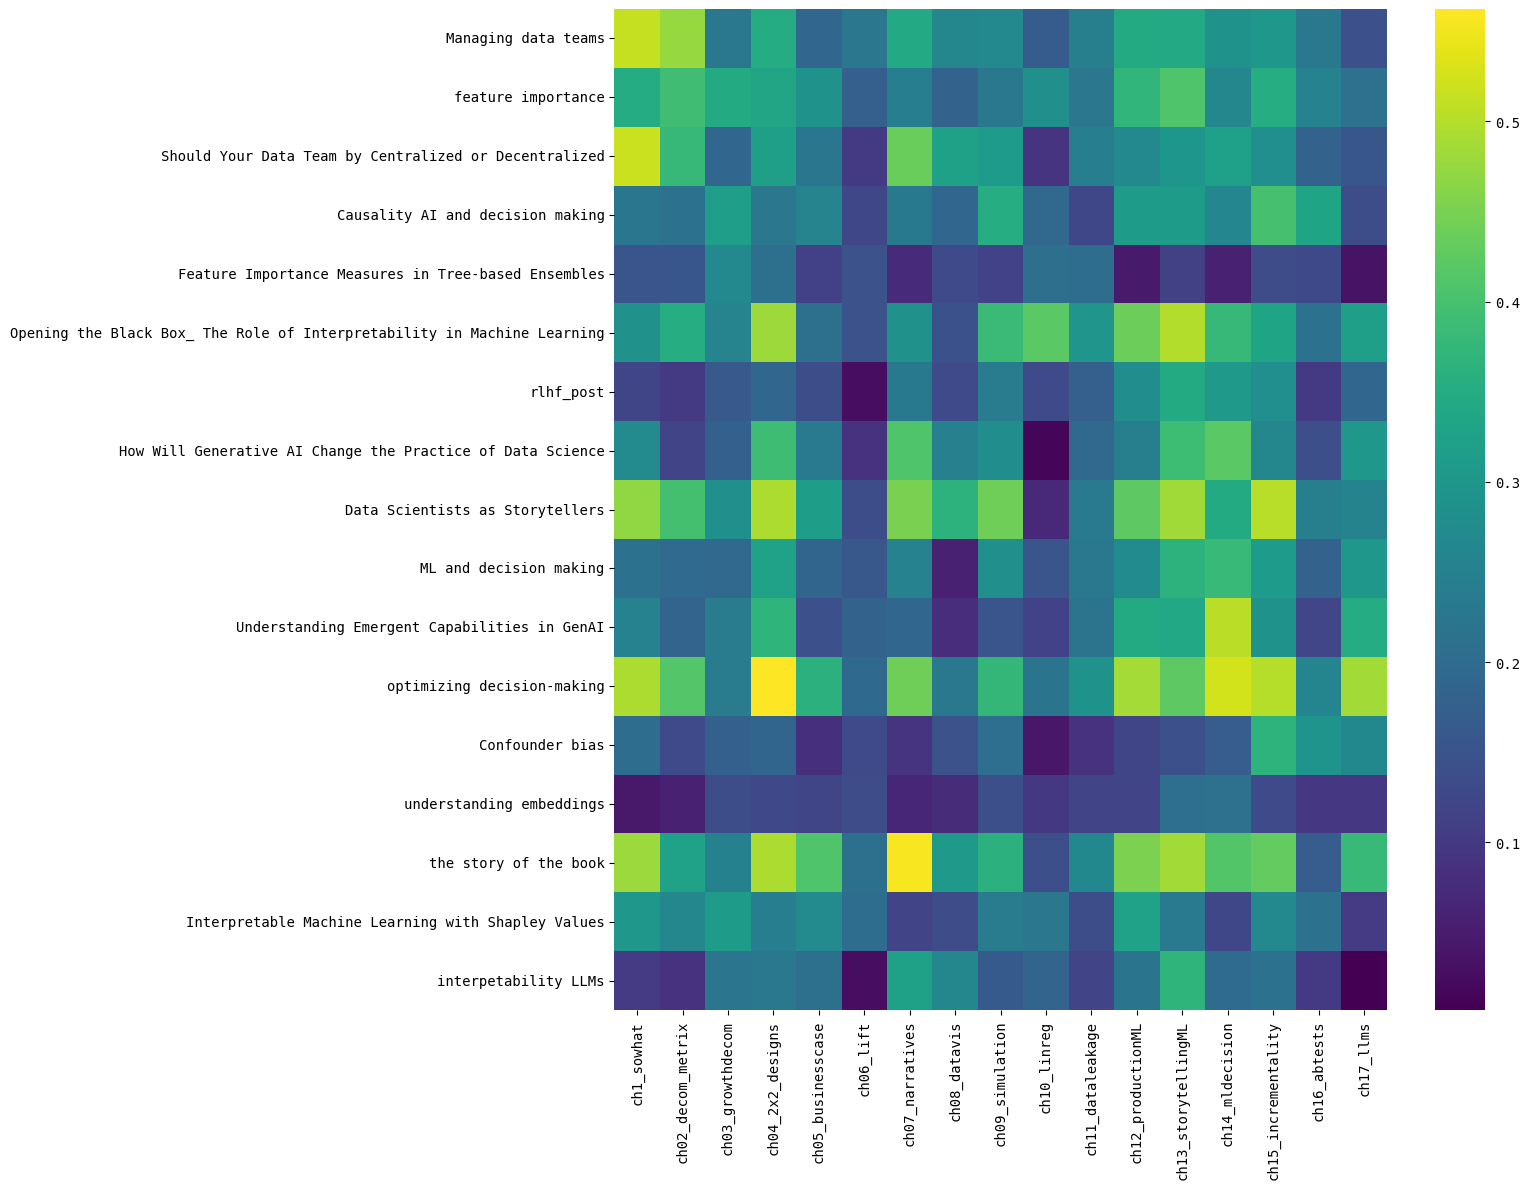

In [50]:
plt.figure(figsize=(16,12))
sns.heatmap(df_dist.T, cmap='viridis')


In [51]:
def plot_slopegraph(df_dist, axis, ax):
  max_similarity = df_dist.idxmax(axis=axis)
  if axis==1:
    sg_dict_l = {df_dist.index[i]:2*i for i in range(len(df_dist.index))}
    sg_dict_r = {df_dist.columns[i]:2*i for i in range(len(df_dist.columns))}
    labsx = ['Chapters','Blogs']
  else:
    sg_dict_l = {df_dist.columns[i]:2*i for i in range(len(df_dist.columns))}
    sg_dict_r = {df_dist.index[i]:2*i for i in range(len(df_dist.index))}
    labsx = ['Blogs','Chapters']
  # ready to plot
  ax.scatter([1]*len(sg_dict_l), sg_dict_l.values(), color='0.5', edgecolor='k')
  ax.scatter([2]*len(sg_dict_r), sg_dict_r.values(), color='0.5', edgecolor='k')
  set_right = set()
  for i in range(len(max_similarity)):
    lab_i = max_similarity.index[i]
    y1i = sg_dict_l[lab_i]
    labji = max_similarity.loc[lab_i]
    y2i = sg_dict_r[labji]
    ax.annotate('', xy=(2, y2i), xytext=(1, y1i),
              arrowprops=dict(facecolor='0.5', shrink=0.0, width=0.5,
                              headwidth=1,ls='dotted'))
    ax.text(0.95*1,y1i, lab_i, horizontalalignment='right', verticalalignment='center',)
    if labji not in set_right:
      ax.text(1.01*2,y2i, labji, horizontalalignment='left', verticalalignment='center')
      set_right.add(labji)

  ax.set_xticks([1,2])
  ax.set_yticks([])
  ax.set_xticklabels(labsx, fontsize=14)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  return ax

Text(0.5, 1.0, 'Similarity of Posts and Chapters')

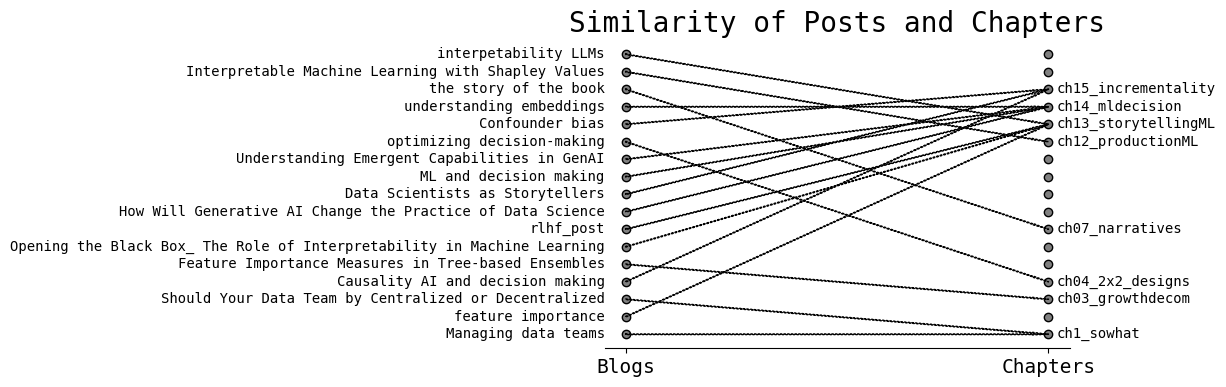

In [52]:
fig, ax = plt.subplots()
ax = plot_slopegraph(df_dist, axis=0, ax=ax)
ax.set_title('Similarity of Posts and Chapters')

Text(0.5, 1.0, 'Similarity of Chapters and Posts')

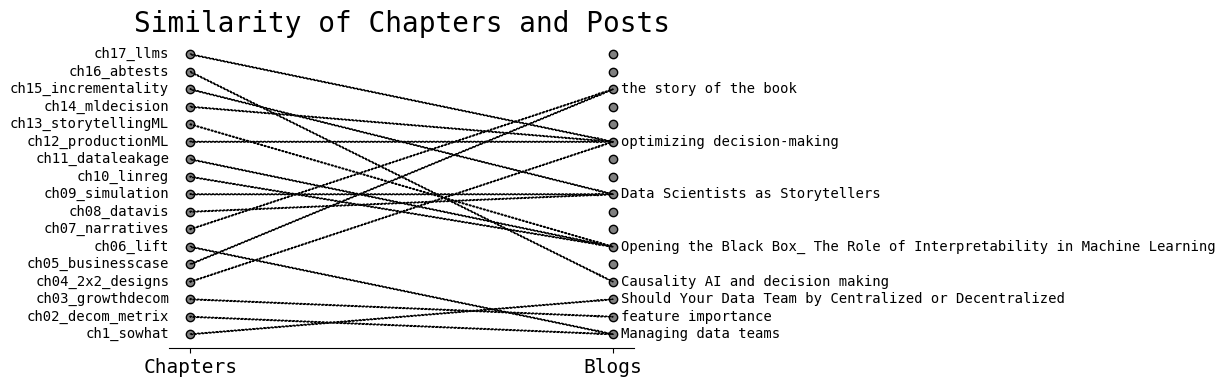

In [53]:
fig, ax = plt.subplots()
ax = plot_slopegraph(df_dist, axis=1, ax=ax)
ax.set_title('Similarity of Chapters and Posts')

# Let's do some topic modeling

We will follow these steps:
1. Embed a document
2. Reduce dimensions with `UMAP`
3. Cluster with `HDBSCAN`
4. Use [`BERTopic`](https://maartengr.github.io/BERTopic/) to interpret the clusters


Note that I'm following the great preview of [Hands-On Large Language Models](https://learning.oreilly.com/library/view/hands-on-large-language/9781098150952/).

The authors are really great:
* [Jay Alammar](http://jalammar.github.io/) has written extensively about LLMs.
* [Maarten Grootendorst](https://www.maartengrootendorst.com/) is the author of `BERTopic` and other useful libraries.  We are using BERTopic now.

In [73]:
def relabel_docs(df_topic_doc, docs):
  len_txt = 30
  df_topic_doc['label'] = np.nan
  for i in df_topic_doc.index:
    doci = df_topic_doc.Document.loc[i]
    for j,bgj in enumerate(docs):
      docj = bgj
      if doci[:len_txt] == docj[:len_txt]:
        df_topic_doc['label'].loc[i] = blog_labs_c[j]

  return df_topic_doc

def find_topics(topic_model,docs):
  topics, probs = topic_model.fit_transform(blog_list)
  df_topic = topic_model.get_topic_info()
  df_topic_doc = topic_model.get_document_info(blog_list)
  df_topic_doc = relabel_docs(df_topic_doc, docs)
  return df_topic_doc



In [ ]:
def plot_heatmap(topic_df, ax):
  df_ct = pd.crosstab(topic_df.Name, topic_df.label).T
  df_ct.index.name, df_ct.columns.name = None, None
  dict_cl = {col: f'Cluster {c}' for c,col in enumerate(df_ct.columns)}
  relabel_cl = ['\n'.join(s.split('_')[1:]) for s in dict_cl.keys()]
  df_ct.rename(columns=dict_cl, inplace=True)
  ax = sns.heatmap(df_ct, cbar=False, cmap='binary', linewidths=0.5, linecolor='black')
  xtl = ax.set_xticklabels(relabel_cl)
  ax.set_xlim(0, df_ct.shape[1]+0.5)
  ax.set_ylim(-0.1, df_ct.shape[0]+0.5)
  ax.set_title('Clusters with BERTopic')
  return df_ct, ax

In [74]:
# first pass:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = umap.UMAP(n_neighbors=4, n_components=2, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english")
dim_model = PCA(n_components=5)
ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()
cluster_model = KMeans(n_clusters=4)
# Build model
topic_model = BERTopic(
  embedding_model=embedding_model,
  #umap_model=dim_model,
  umap_model=umap_model,
  #hdbscan_model=hdbscan_model,
  hdbscan_model=cluster_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=representation_model)
topics0 = find_topics(topic_model,docs=blog_list)

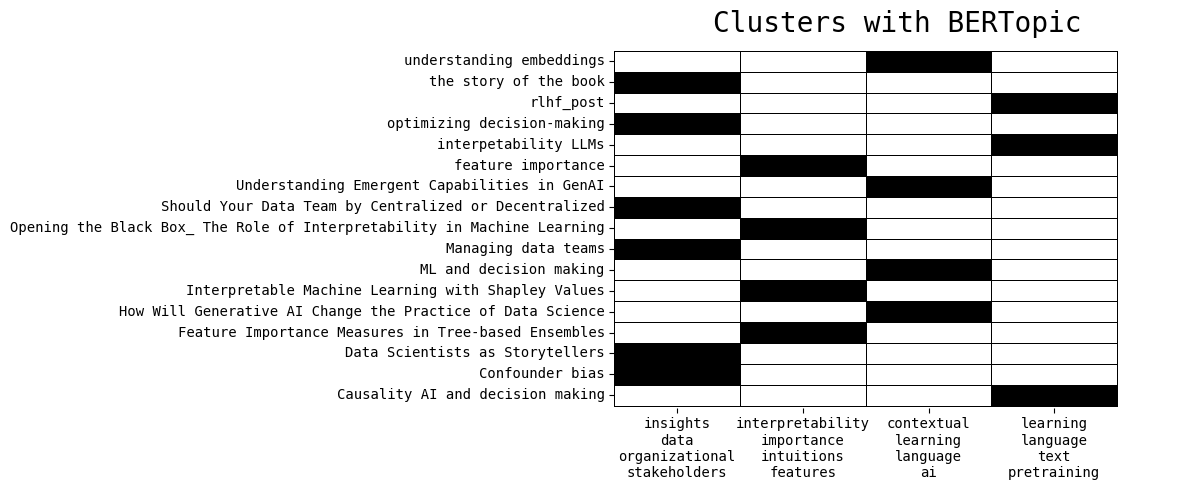

In [165]:
fig, ax = plt.subplots(figsize=(12,5))
df_ct, ax = plot_heatmap(topics0, ax)

In [177]:
dim_model = PCA(n_components=10)
cluster_model = KMeans(n_clusters=5)
# Build model
topic_model1 = BERTopic(
  embedding_model=embedding_model,
  umap_model=dim_model,
  hdbscan_model=cluster_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=representation_model
)
topics1 = find_topics(topic_model1,docs=blog_list)

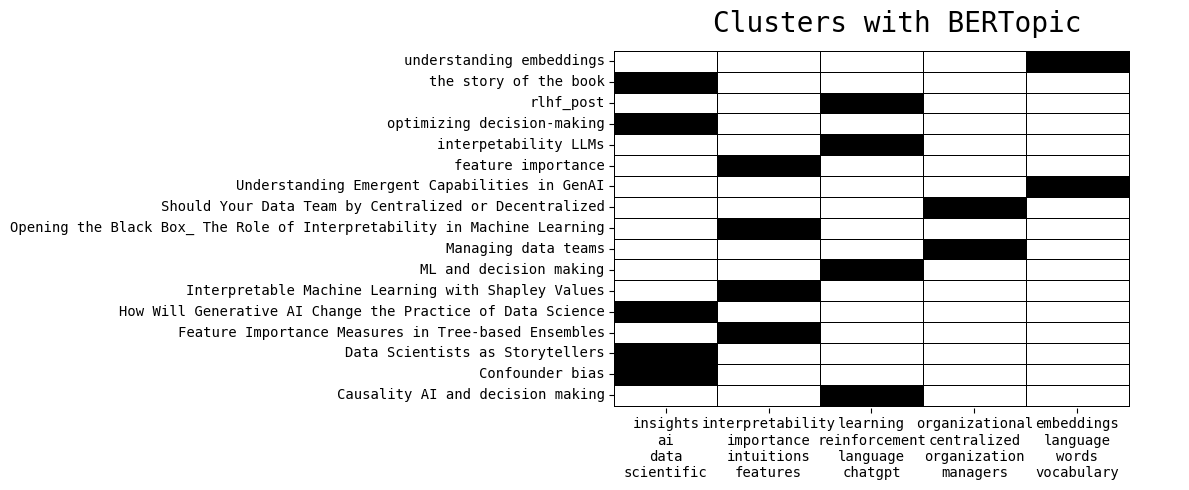

In [178]:
fig, ax = plt.subplots(figsize=(12,5))
df_ct, ax = plot_heatmap(topics1, ax)